# CLTV Prediction with BG-NBD and Gamma-Gamma Models

## Business Problem 
FLO, a shoe store, wants to define a roadmap for their sales and marketing actions. For the company to make medium-long term plans, the potential value that existing customers will bring should be predicted.

## Dataset Summary
The dataset consists of information obtained from the past shopping behavior of customers who made their last purchase as 
Omnichannel (both online and offline purchases) from FLO in 2020 - 2021.

**master_id:** Unique customer number.  
**order_channel:** The channel that the purchase was made. (Android, iOS, Desktop, Mobile)  
**last_order_channel:** The channel that the  last purchase was made.  
**first_order_date:** First purchase date of the customer.  
**last_order_date:** Last purchase date of the customer.  
**last_order_date_online:** Last online purchase date of the customer.  
**last_order_date_offline:** Last offline purchase date of the customer.  
**order_num_total_ever_online:** Total online purchase count of the customer.  
**order_num_total_ever_offline:** Total offline purchase count of the customer.  
**customer_value_total_ever_offline:** Total value spent on offline purchases by the customer.  
**customer_value_total_ever_online:** Total value spent on online purchases by the customer.  
**interested_in_categories_12:** The categories that customer purchased from in the last 12 months. 


In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.6 MB/s eta 0:00:00


In [2]:
import datetime as dt
import pandas as pd
import lifetimes
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 225)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df_ = pd.read_csv("../input/flo-data-20k/flo_data_20k.csv")


In [4]:
df = df_.copy()

In [5]:
# general_info function is written to examine the general shape of the dataset
def general_info (dataframe):
    print("---------------- Shape ----------------")
    print(dataframe.shape,"\n\n")
    print("---------------- Head ----------------")
    print(dataframe.head(10),"\n\n")
    print("---------------- Variables ----------------")
    print(dataframe.columns,"\n\n")
    print("---------------- Statistics ----------------")
    print(dataframe.describe().T,"\n\n")
    print("---------------- Null Value ----------------")
    print(dataframe.isnull().sum(),"\n\n")
    print("---------------- Variable Types----------------")
    print(dataframe.info(),"\n\n")
general_info(df)

---------------- Shape ----------------
(19945, 12) 


---------------- Head ----------------
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30      2021-02-26             2021-02-21              2021-02-26                       4.0000                        1.0000   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile       2017-02-08      2021-02-16             2021-02-16              2020-01-10                      19.0000                        2.0000   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App       2019-11-27      2020-11-27             2020-11-27              2019-12-01                       3.0000                        2.0000   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Andr

In [6]:
# For outlier value analysis, 3 functions are written to define thresholds, replace outliers and check outliers respectively. 
def outlier_thresholds(dataframe, variable):
    """
    Defines upper and lower limits to investigate outlying values. 
    The limits are defined by adding and subtracting 1.5 interquantile 
    range values respectively to 3rd quartile and 1st quartile.
    
    Parameters
    ----------
    dataframe : dataframe
        The dataframe to be used.
    variable : dataframe variable
        The variable whose limits are intended to be calculated.
    
    Returns
    -------
    low_limit: Lower limit for outlier check.
    upper_limit: Upper limit for outlier check.   
    """
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [7]:
def replace_with_thresholds(dataframe, variable):
    """
       Replaces the outlying values lower than low_limit and higher than
       up_limit variables which are defined by outlier_threshold function.

       Parameters
       ----------
       dataframe : dataframe
           The dataframe to be used.
       variable : dataframe variable
           The variable whose limits are intended to be implemented.
       """
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)

In [8]:
def check_outlier(dataframe, col_name):
    """
     Checks if the dataframe variable has any values higher 
     than upper limit and lower than lower limit

       Parameters
       ----------
       dataframe : dataframe
           The dataframe to be used.
       col_name : dataframe variable
           The variable whose values are compared to limits.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        print(f"{col_name}\nLower limit = {low_limit}\nUpper limit = {up_limit}")
        return True
    else:
        print(f"{col_name}\nLower limit = {low_limit}\nUpper limit = {up_limit}")
        return False

In [9]:
# When the statistical properties are examined, it can be seen that there are abnormal jumps from 75% values to max values which can imply that there are outlying values that we should eliminate to have a better CLTV analysis.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


order_num_total_ever_online
Lower limit = -27.5
Upper limit = 48.5

Any outliers: True


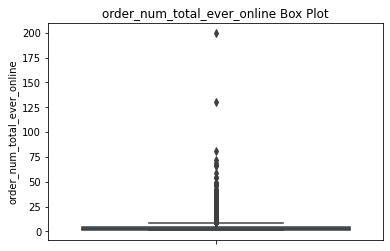


---------------------------------------------------------

order_num_total_ever_offline
Lower limit = -8.0
Upper limit = 16.0

Any outliers: True


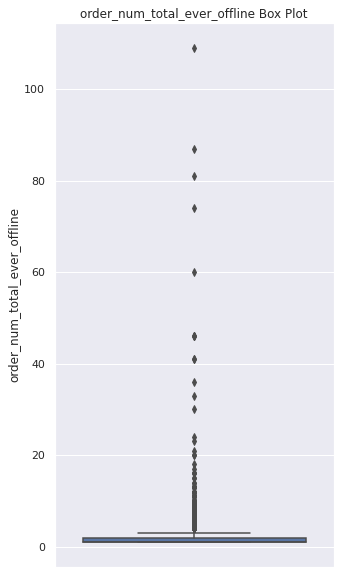


---------------------------------------------------------

customer_value_total_ever_offline
Lower limit = -1779.9452000000003
Upper limit = 3019.8820000000005

Any outliers: True


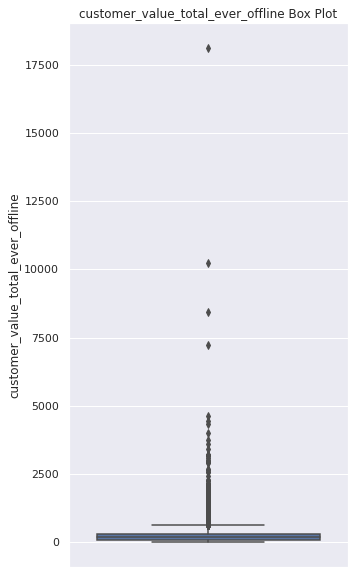


---------------------------------------------------------

customer_value_total_ever_online
Lower limit = -4615.7406000000055
Upper limit = 7799.541000000008

Any outliers: True


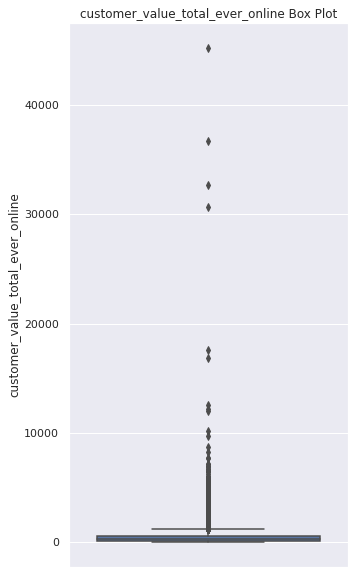


---------------------------------------------------------



In [10]:
# The appropriate columns for outlier analysis are stored in a list and checked if there are outlying values. Then replace_with_thresholds function is used to equate outlying values to limits.
columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    print(f"\nAny outliers: {check_outlier(df,col)}")
    sns.boxplot(data = df, y = col)
    sns.set(rc={"figure.figsize":(5, 10)})
    plt.title(f"{col} Box Plot")
    plt.show()
    print("\n---------------------------------------------------------\n")
    replace_with_thresholds(df, col)

In [11]:
# After this process, it can be seen that max values are dropped to more reasonable values. Now we can proceed with CLTV analysis steps.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.0920,3.8095,1.0000,1.0000,2.0000,4.0000,48.0000
order_num_total_ever_offline,19945.0000,1.8862,1.4347,1.0000,1.0000,1.0000,2.0000,16.0000
customer_value_total_ever_offline,19945.0000,251.9213,251.0237,10.0000,99.9900,179.9800,319.9700,3020.0000
customer_value_total_ever_online,19945.0000,489.7057,632.6098,12.9900,149.9800,286.4600,578.4400,7800.0000


In [12]:
# New variables are defined for total order values and total customer spendings.
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


In [13]:
# The columns that has date value inside has their data types as object. So they are transformed into date
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

df[date_columns].dtypes

first_order_date           datetime64[ns]
last_order_date            datetime64[ns]
last_order_date_online     datetime64[ns]
last_order_date_offline    datetime64[ns]
dtype: object

In [14]:
# For time analysis purposes, an analysis date is defined which is 2 days later than the last transaction.
print(df["last_order_date"].max())
analysis_date = dt.datetime(2021,6,1) 

2021-05-30 00:00:00


In [15]:
# CLTV dataframe is formed by customer ids, weekly recency, weekly tenure, frequency and average monetary.
cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]

# Recency is the date difference betwwen first and last orders of a customer
cltv_df["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]) / dt.timedelta(weeks=1)

# Tenure is the date difference betwwen first order of a customer and analysis date.
cltv_df["T_weekly"] = (analysis_date - df["first_order_date"]) / dt.timedelta(weeks=1)

cltv_df["frequency"] = df["order_num_total"]
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900


In [16]:
# BG/NBD model is prepared and parameters are obtained.
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [17]:
# Expected sale values of customers are calculated for following 3 month interval.
cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960


In [18]:
# Expected sale values of customers are calculated for following 6 month interval.
cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921


In [19]:
# Gamma-Gamma model is fitted and average values of customers are calculated.
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'],
        cltv_df['monetary_cltv_avg'])

cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                       cltv_df['monetary_cltv_avg'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251


In [20]:
# CLTV values for 6 months are calculated.
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6, # in months
                                   freq="W", # Frequency type of T
                                   discount_rate=0.01)
cltv_df["cltv"] = cltv

cltv_df.head()


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117


In [21]:
# The customers with top 20 CLTV values are presented.
cltv_df.sort_values("cltv",ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,2.1888,1449.0605,3327.7770
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,3.9402,767.3606,3172.3944
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,1.4445,1127.6115,1708.9821
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,3.1306,506.1667,1662.6135
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123,166.7123,1628.8874
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,2.5309,611.4926,1623.8127
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,1.5878,923.6800,1538.8559
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614,262.0729,1529.2280
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676,229.6069,1485.8192
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,1.7431,778.0504,1422.9997


In [22]:
# Customers are segmented to 4 groups according to their 6 month CLTV values
cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D


In [23]:
# The mean values of recency, frequency and monetary are observed for each segment.
cltv_df.groupby("cltv_segment").agg(["max","mean","count"]).reset_index()


cltv_segment recency_cltv_weekly                T_weekly                frequency              monetary_cltv_avg                exp_sales_3_month              exp_sales_6_month              exp_average_value           \
                               max     mean count      max     mean count       max   mean count               max     mean count               max   mean count               max   mean count               max     mean   
0            D            432.5714 139.0002  4987 436.2857 162.1832  4987   18.0000 3.7688  4987          284.9850  93.1516  4987            1.0498 0.4089  4987            2.0995 0.8178  4987          306.5909  98.6911   
1            C            433.0000  92.6295  4986 434.7143 112.8183  4986   32.0000 4.4047  4986          342.8400 125.7885  4986            1.5684 0.5254  4986            3.1369 1.0509  4986          368.3901 132.2506   
2            B            415.5714  81.9884  4986 423.5714 100.3265  4986   50.0000 5.0927  4986          539.9850 160.6366  4986            1.7822 0.6011  4986            3.5643 1.2022  4986          578.9751 168.0006   
3            A            433.4286  67.4271  4986 437.1429  82.5497  4986   57.0000 6.6466  4986         1401.8000 228.8311  4986            4.6561 0.7730  4986            9.3123 1.5461  4986         1449.0605 238.0240   

             cltv                 
  count       max     mean count  
0  4987  112.2454  80.3405  4987  
1  4986  165.4689 138.3115  4986  
2  4986  240.0579 199.5328  4986  
3  4986 3327.7770 362.3155  4986

<AxesSubplot:title={'center':'Expected Average Monetary'}, xlabel='exp_average_value', ylabel='cltv_segment'>

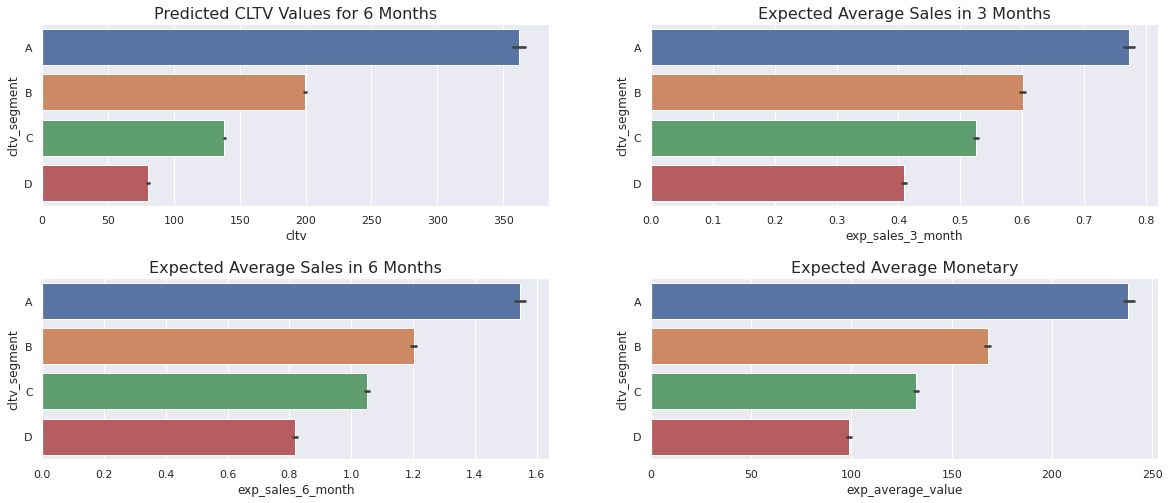

In [24]:
fig, axes = plt.subplots(2,2,figsize=(20, 8))
plt.subplots_adjust(hspace= 0.4)
axes[0,0].set_title("Predicted CLTV Values for 6 Months", fontsize = 16)
axes[0,1].set_title("Expected Average Sales in 3 Months", fontsize = 16)
axes[1,0].set_title("Expected Average Sales in 6 Months", fontsize = 16)
axes[1,1].set_title("Expected Average Monetary", fontsize = 16)
sns.barplot(ax=axes[0,0], y = "cltv_segment", x = "cltv", data = cltv_df, order = ["A","B","C","D"])
sns.barplot(ax=axes[0,1], y = "cltv_segment", x = "exp_sales_3_month", data = cltv_df, order = ["A","B","C","D"])
sns.barplot(ax=axes[1,0] ,y = "cltv_segment", x = "exp_sales_6_month", data = cltv_df, order = ["A","B","C","D"])
sns.barplot(ax=axes[1,1], y = "cltv_segment", x = "exp_average_value", data = cltv_df, order = ["A","B","C","D"])

### Insights
It can be observed that segment A has a significant difference in CLTV values according to other segments. They should be treated as primary targets to maintain and to increase their values to the store. Segments C and D has little value to the company as their CLTV values are observed. These groups can be merged to be analyzed as one since it can be pointless to make separate analyses for them. Also, it can be observed that segment A has a remarkable gap in average monetary values and expected sales, the values are approximately two times larger than the segments C and D.